In [2]:
import numpy as np
import os
import torch

root = '/vulcanscratch/mgwillia/unsupervised-classification/imagenet-'
btwins_neighbors = np.load(root + 'btwins/pretext/topk-neighbors.npy')[:,1:]
dc_neighbors = np.load(root + 'dc/pretext/topk-neighbors.npy')[:,1:]
moco_neighbors = np.load(root + 'moco/pretext/topk-neighbors.npy')[:,1:]
sclr_neighbors = np.load(root + 'sclr/pretext/topk-neighbors.npy')[:,1:]
simsiam_neighbors = np.load(root + 'simsiam/pretext/topk-neighbors.npy')[:,1:]
sup_neighbors = np.load(root + 'sup/pretext/topk-neighbors.npy')[:,1:]
swav_neighbors = np.load(root + 'swav/pretext/topk-neighbors.npy')[:,1:]

print(btwins_neighbors.shape)
print(moco_neighbors.shape)
print(sclr_neighbors.shape)
print(sup_neighbors.shape)
print(swav_neighbors.shape)

method_names = ['btwins', 'dc', 'moco', 'simclr', 'simsiam', 'supervised', 'swav']
#method_names = ['btwins', 'moco', 'simclr', 'supervised', 'swav']
neighbors = [btwins_neighbors, dc_neighbors, moco_neighbors, sclr_neighbors, simsiam_neighbors, sup_neighbors, swav_neighbors]
#neighbors = [btwins_neighbors, moco_neighbors, sclr_neighbors, sup_neighbors, swav_neighbors]

print('class-agonstic NN similarity, using 50 NNs:')
sim_map = {}
num_images_to_sample = 100000 #TODO: change to 100k, eventually do all of them!
for i in range(len(neighbors)):
    neighbors_a = neighbors[i]
    for j in range(i + 1, len(neighbors)):
        print(method_names[i], method_names[j])
        neighbors_b = neighbors[j]
        num_common_neighbors = 0
        indices_to_sample = np.random.choice(range(neighbors_a.shape[0]), size=num_images_to_sample, replace=False).tolist()
        for k in indices_to_sample:
            num_common_neighbors += np.intersect1d(neighbors_a[k], neighbors_b[k]).shape[0]
        sim = num_common_neighbors / (num_images_to_sample * neighbors_a.shape[1])
        print(sim)
        if method_names[i] not in sim_map:
            sim_map[method_names[i]] = {}
        if method_names[j] not in sim_map:
            sim_map[method_names[j]] = {}
        sim_map[method_names[i]][method_names[j]] = sim
        sim_map[method_names[j]][method_names[i]] = sim
        
print(sim_map)

(1331167, 50)
(1331167, 50)
(1331167, 50)
(1331167, 50)
(1331167, 50)
class-agonstic NN similarity, using 50 NNs:
btwins dc
0.4277198
btwins moco
0.4515074
btwins simclr
0.478198
btwins simsiam
0.4905116
btwins supervised
0.2464458
btwins swav
0.393951
dc moco
0.3870896
dc simclr
0.3864422
dc simsiam
0.389928
dc supervised
0.2651564
dc swav
0.5387848
moco simclr
0.4483154
moco simsiam
0.437007
moco supervised
0.2304462
moco swav
0.3755454
simclr simsiam
0.4891858
simclr supervised
0.19741
simclr swav
0.4014232
simsiam supervised
0.203305
simsiam swav
0.3774638
supervised swav
0.2510282
{'btwins': {'dc': 0.4277198, 'moco': 0.4515074, 'simclr': 0.478198, 'simsiam': 0.4905116, 'supervised': 0.2464458, 'swav': 0.393951}, 'dc': {'btwins': 0.4277198, 'moco': 0.3870896, 'simclr': 0.3864422, 'simsiam': 0.389928, 'supervised': 0.2651564, 'swav': 0.5387848}, 'moco': {'btwins': 0.4515074, 'dc': 0.3870896, 'simclr': 0.4483154, 'simsiam': 0.437007, 'supervised': 0.2304462, 'swav': 0.3755454}, 'simc

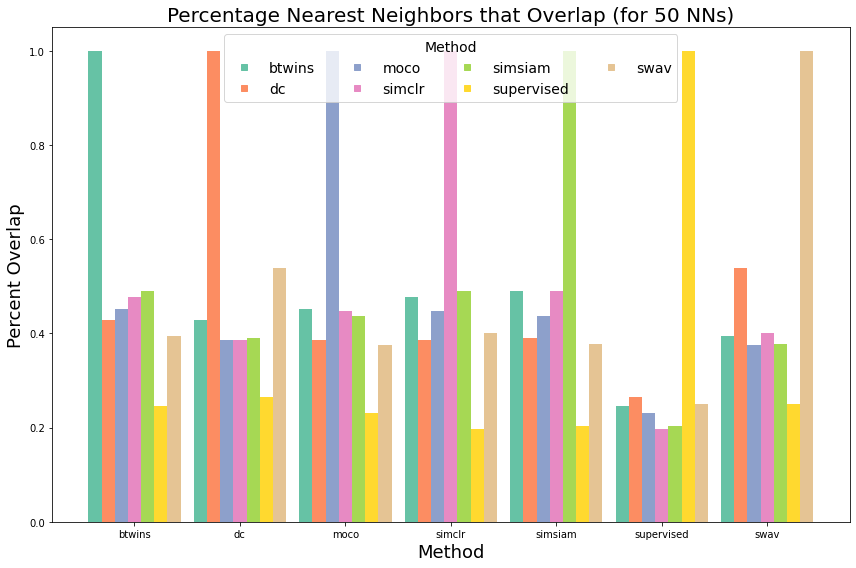

In [3]:
## TODO: consider adding linear eval overlaps as negative bars

import torch
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
cmap = plt.get_cmap('Set2')
colormap = np.array(list(cmap.colors))

fig, ax = plt.subplots(1, 1)
x_s, heights, colors = [], [], []
counter = 1
for method_a in method_names:
    for i, method_b in enumerate(method_names): 
        if method_a != method_b:
            x_s.append(counter)
            heights.append(sim_map[method_a][method_b])
            colors.append(i)
        else:
            x_s.append(counter)
            heights.append(1.0)
            colors.append(i)
        counter += 1
    counter += 1

ax.bar(x_s, heights, 1.0, color=colormap[colors])

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colormap[i]) for i in range(7)]
ax.legend(handles,
          method_names,
          title='Method',
          title_fontsize=14,
          scatterpoints=1,
          ncol=4,
          fontsize=14)

middle = len(method_names) // 2
offset = 0.5 + len(method_names) / 2 - middle
ax.set_xticks(offset + np.array(list(range(middle, (1 + len(method_names)) * len(method_names) + middle, 1 + len(method_names)))))
ax.set_xticklabels(method_names)
plt.title(f'Percentage Nearest Neighbors that Overlap (for 50 NNs)', fontsize=20)
plt.xlabel('Method', fontsize=18)
plt.ylabel('Percent Overlap', fontsize=18)

fig.tight_layout()
plt.savefig(f'nn_overlap', bbox_inches = 'tight',
    pad_inches = 0.1)